In [2]:
!pip install imutils

In [19]:
import cv2 as cv
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.metrics import Precision, Recall

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/Garbage classification'

In [6]:
target_size = (224, 224)
waste_labels = {'cardboard':0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash':5}

In [7]:
def load_dataset(path):
    x = [] # x: Görüntülere ait matris bilgilerini uttat
    labels = [] # labels: Görüntüünün ait olduğu sınıf bilgisini tutar
    image_path = sorted(list(paths.list_images(path)))

    for image_path in image_path:
        img = cv.imread(image_path)
        img = cv.resize(img, target_size)
        x.append(img)
        label = image_path.split(os.path.sep)[-2]
        labels.append(waste_labels[label])

    # veri seti random birşekilde karıştırıyoruz
    x, labels = shuffle(x, labels, random_state=42)

    print(f"x boyutu: {np.array(x).shape}")
    print(f"Label sınıfı sayısı: {len(np.unique(labels))} Gözlem Sayısı: {len(labels)}")

    return x, labels

In [8]:
x, labels = load_dataset(dir_path)

x boyutu: (2527, 224, 224, 3)
Label sınıfı sayısı: 6 Gözlem Sayısı: 2527


In [9]:
input_shape =(np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)

Veri Seinden Örnek Gösterme

In [10]:
def visualize_img(image_batch, label_batch):
  # image_batch: görüntülere ait matris bilgilerini tutar
  # label_batch: Görüntünün ait olduğu sınıf bilgisini tutan listeyi tutar
  plt.figure(figsize= (10,15))
  for n in range(10):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes = 6)[n]==1][0].title())

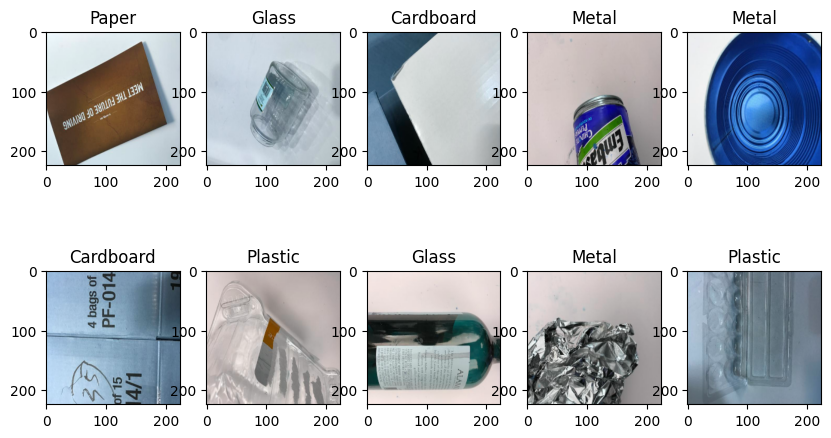

In [11]:
visualize_img(x, labels)

Veriyi Hazırlamak (Data Preparation)

In [12]:
train = ImageDataGenerator(horizontal_flip = True,
                           vertical_flip = True,
                           validation_split = 0.1,
                           rescale = 1./255,
                           shear_range = 0.1,
                           zoom_range = 0.1,
                           width_shift_range=0.1,
                           height_shift_range = 0.1)

test = ImageDataGenerator(rescale=1/255,
                          validation_split=0.1)

In [31]:
train_generator = train.flow_from_directory(directory=dir_path,
                                            target_size=(target_size),
                                            class_mode='categorical',
                                            subset='training')

test_generator= test.flow_from_directory(directory = dir_path,
                                         target_size=(target_size),
                                         batch_size = 251,
                                         class_mode = 'categorical',
                                         subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


MODELİNG(Modelleme)

Sequential

cnn katmanı(Convolution laer, Conv2D)

pooling

activasyon katmanı

flatten katmanı

dense kantmanı

droutput katmanı

In [32]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', input_shape = (input_shape), activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2, strides = (2,2)))

model.add(Conv2D(filters=64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=2, strides = (2,2))
)
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2, strides = (2,2)))

model.add(Flatten())

model.add(Dense(units = 64, activation= 'relu'))
model.add(Dropout(rate = 0.2))

model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(rate = 0.2))

model.add(Dense(units=6, activation= 'softmax'))

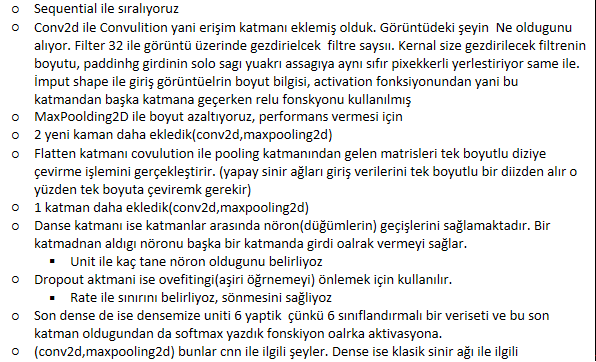

In [33]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,645,830 (6.28 MB)

 Trainable params: 1,645,830 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

Optimizasyon ve Değerlendirme Metrikerlin Ayr,arlanılması

In [34]:
model.compile(loss = 'categorical_crossentropy',  optimizer = 'adam', metrics = [Precision(), Recall(),'acc'])

In [35]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 50, verbose = 1, mode =  "min"),
             ModelCheckpoint(filepath = 'mymodel.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)
             ]

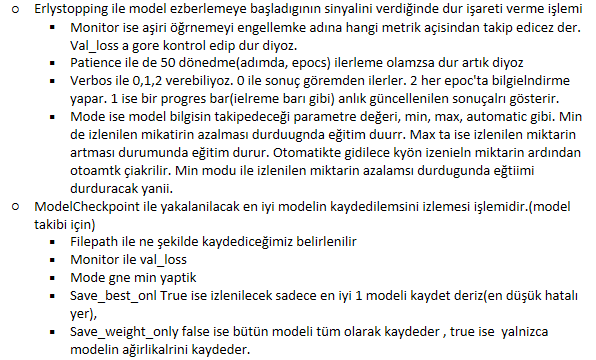

Modelin Eğitilmesi

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    steps_per_epoch=2276 // 32,
    validation_steps=251 // 32
)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - acc: 0.2003 - loss: 1.7766 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_acc: 0.2351 - val_loss: 1.7119 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - acc: 0.0938 - loss: 1.7842 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_acc: 0.2351 - val_loss: 1.7143 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - acc: 0.2202 - loss: 1.7429 - precision_1: 0.3194 - recall_1: 2.0624e-04 - val_acc: 0.2948 - val_loss: 1.6171 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - acc: 0.1875 - loss: 1.6776 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_acc: 0.2829 - val_loss: 1.6261 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - acc: 0.3119 - loss: 1.6077 - precision_1: 0.7704 - rec

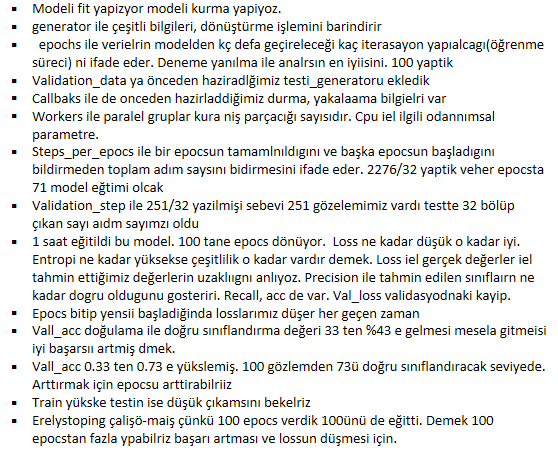

Accuracy ve Loss Grafikleri

In [ ]:
#accuracy grafigi#
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label = 'Training Accuracy')
plt.plot(history.history['val_acc'], label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Valdiation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([min(plt.ylim()),1])

#loss grafiği#
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Valdiation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, [min(plt.ylim())])

Değerlendirme

In [ ]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size = 32)

In [ ]:
print("Test Loss: ", (100.0*loss))
print("Test Precision: ", (100.0*precision))
print("Test Recall: ", (100.0*recall))
print("Test Accuracy: ", (100.0*acc))

In [ ]:
x_test, y_test = test.generator.next()
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [ ]:
target_name = list(waste_labels.keys())

In [ ]:
print(classification_report(y_test, y_pred, target_names=target_name))

In [ ]:
#Confusion Matrix (Karmaşıklık Matrisi)

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion Matrix', cmap = plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:np.newaxis]

  plt.figure(figsize=(8,6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label', fontweight = 'blod')
  plt.xlabel('Predicted label', fontweight = 'bold')

In [ ]:
plot_confusion_matrix(cm, waste_labels.keys(), title = 'Confision Matrix', cmap = plt.cm.OrRd)

Modelin Kurulması ve Test Edilmesi

In [ ]:
waste_labels = {0: 'cardboard', 1: 'glass, 2: metal, 3: paper, 4: plastic, 5: trash'}

In [ ]:
def model_testing(path):
  img = image.load_img(path, target_size=(target_size))
  img= image.img_to_array(img, dtype = np.yint8)
  img = np.array(img)/255.0
  p = model.predict(img.reshape(1, 224, 224, 3))
  predicted_class = np.argmax(p[0])
  return img, p, predicted_class

In [ ]:
img1 , p1 , predictedclass1 = model_testing('/content/drive/MyDrive/Colab Notebooks/Garbage classification/metal/metal100.jpg')
img2 , p2 , predictedclass2 = model_testing('/content/drive/MyDrive/Colab Notebooks/Garbage classification/glasss/glass105.jpg')
img3 , p3 , predictedclass3 = model_testing('/content/drive/MyDrive/Colab Notebooks/Garbage classification/cardboard/cardboard103.jpg')
img4 , p4 , predictedclass4 = model_testing('/content/drive/MyDrive/Colab Notebooks/Garbage classification/paper/paper106.jpg')


In [ ]:
plt.figure(figsize=(20,60))

plt.subplot(141)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title('Maxmum robability: ' + str(np.max(p1[0],axis=-1)) + "\n" + "Predicted Class:" , str(waste_labels[predictedclass1]))
plt.imshow(img1)

plt.subplot(142)
plt.axis('off')
plt.imshow(img2.squeeze())
plt.title('Maxmum robability: ' + str(np.max(p2[0],axis=-1)) + "\n" + "Predicted Class:" , str(waste_labels[predictedclass2]))
plt.imshow(img2)

plt.subplot(143)
plt.axis('off')
plt.imshow(img3.squeeze())
plt.title('Maxmum robability: ' + str(np.max(p3[0],axis=-1)) + "\n" + "Predicted Class:" , str(waste_labels[predictedclass3]))
plt.imshow(img3)

plt.subplot(144)
plt.axis('off')
plt.imshow(img4.squeeze())
plt.title('Maxmum robability: ' + str(np.max(p4[0],axis=-1)) + "\n" + "Predicted Class:" , str(waste_labels[predictedclass4]))
plt.imshow(img4)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/garbage_classification_model.h5')